In [1]:
# 필요 라이브러리
import numpy as np
import pandas as pd
import holidays
import re

# 모델 구축 라이브러리
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# 시각화 라이브러리
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
data = pd.read_csv('movie_finished_toFDA_V9.csv')
print(data.shape)
data.head()

(6135, 172)


,naver_movie_code,kobis_movie_code,movie_title,release_date,DoW_release,Date,DoW,MoY,D_D,DailyTotal,...,국적평균누적관객수,국적평균스크린수,등급평균관객수,등급평균누적관람객수,등급평균스크린수,7days_before,5days_before,Day_of_release,5days_after,7days_after
0,107374,20142641,나를 잊지 말아요,2016-01-07,Thursday,2016-01-07,Thursday,January,0,612,...,859493,95,9090,596341,79,11,11,13,6,33
1,107374,20142641,나를 잊지 말아요,2016-01-07,Thursday,2016-01-08,Friday,January,1,332,...,859493,95,9090,596341,79,11,11,13,6,33
2,107374,20142641,나를 잊지 말아요,2016-01-07,Thursday,2016-01-09,Saturday,January,2,394,...,859493,95,9090,596341,79,11,11,13,6,33
3,107374,20142641,나를 잊지 말아요,2016-01-07,Thursday,2016-01-10,Sunday,January,3,205,...,859493,95,9090,596341,79,11,11,13,6,33
4,107374,20142641,나를 잊지 말아요,2016-01-07,Thursday,2016-01-11,Monday,January,4,246,...,859493,95,9090,596341,79,11,11,13,6,33


## 데이터 전처리

### 데이터 전처리 - 데이터 타입 변환

In [3]:
# 1. 바꿀 column 정의
datetime_columns = ['release_date', 'Date']
numeric_columns = [
    'NTZ_neg_ratio', 'NTZ_neut_ratio', 'NTZ_pos_ratio', 'NTZ_Entropy',
    'actors_naver_code', 'RV_male', 'RV_female', 'NTZ_review_total',
    'RV_review_total', 'RV_direct_point', 'RV_act_point', 'RV_story_point',
    'RV_visual_point', 'RV_ost_point', 'directors_naver_code'
]
percentage_columns = [
    'RV_teen', 'RV_twenties', 'RV_thirties', 'RV_forties', 'RV_fifties',
    'NTZ_direct_point', 'NTZ_act_point', 'NTZ_story_point',
    'NTZ_visual_point', 'NTZ_ost_point'
]

In [4]:
# 2. 날짜형으로 데이터 바꾸기
for col in datetime_columns:
    try:
        data[col] = pd.to_datetime(data[col], errors='coerce')
        print(f"Converted {col} to datetime.")
    except Exception as e:
        print(f"Error converting {col} to datetime: {e}")

Converted release_date to datetime.
Converted Date to datetime.


In [5]:
# 3. 숫자형으로 데이터 바꾸기
for col in numeric_columns:
    try:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        print(f"Converted {col} to numeric.")
    except Exception as e:
        print(f"Error converting {col} to numeric: {e}")

Converted NTZ_neg_ratio to numeric.
Converted NTZ_neut_ratio to numeric.
Converted NTZ_pos_ratio to numeric.
Converted NTZ_Entropy to numeric.
Converted actors_naver_code to numeric.
Converted RV_male to numeric.
Converted RV_female to numeric.
Converted NTZ_review_total to numeric.
Converted RV_review_total to numeric.
Converted RV_direct_point to numeric.
Converted RV_act_point to numeric.
Converted RV_story_point to numeric.
Converted RV_visual_point to numeric.
Converted RV_ost_point to numeric.
Converted directors_naver_code to numeric.


In [6]:
# 4. 백분위로 데이터 바꾸기
for col in percentage_columns:
    if col in data.columns:
        # Remove the '%' symbol and convert to numeric
        data[col] = data[col].str.replace('%', '', regex=False).astype(float)
        # Rename the column to include "(%)"
        data.rename(columns={col: f"{col} (%)"}, inplace=True)
        print(f"Processed column {col}: Removed '%' and converted to numeric.")
    else:
        print(f"Column {col} not found in the dataset.")

Processed column RV_teen: Removed '%' and converted to numeric.
Processed column RV_twenties: Removed '%' and converted to numeric.
Processed column RV_thirties: Removed '%' and converted to numeric.
Processed column RV_forties: Removed '%' and converted to numeric.
Processed column RV_fifties: Removed '%' and converted to numeric.
Processed column NTZ_direct_point: Removed '%' and converted to numeric.
Processed column NTZ_act_point: Removed '%' and converted to numeric.
Processed column NTZ_story_point: Removed '%' and converted to numeric.
Processed column NTZ_visual_point: Removed '%' and converted to numeric.
Processed column NTZ_ost_point: Removed '%' and converted to numeric.


In [7]:
# 5. 전일대비 컬럼 분할
# 예) '매출액증감(전일대비)' -> '매출액증감', '매출액증감전일대비(%)'
# 예) -27673800 ( -5.7% ) -> -27673800, -5.7% 

def extract_percentage(s):
    match = re.search(r'\( ([^)]+)%\)', s)
    if match:
        return float(match.group(1))
    return None

for col in ['매출액증감(전일대비)', '관객수증감(전일대비)']:
    raw_diff_col = col.replace('(전일대비)', '')
    percentage_col = col + '%'
    data[raw_diff_col] = data[col].str.extract(r'([\d,]+)').astype('int64')

    # Extract the percentage value and convert to float (e.g. '-27673800 ( -5.7% )' -> -5.7)
    data[percentage_col] = data[col].str.split('(').str[1].str.split('%').str[0].astype(float)
    data.drop(columns=[col], inplace=True)

In [8]:
# 6. 잘 변경되었는지 문자형 데이터를 출력하여 확인

# object 타입 열만 필터링
object_columns = data.select_dtypes(include=['object'])

# object 타입 열 이름 출력
print("Object 타입 열 이름:")
print(object_columns.columns.tolist())

# object 타입 열 전체 데이터 출력
print("\nObject 타입 열 데이터:")
print(object_columns.head())

Object 타입 열 이름:
['movie_title', 'DoW_release', 'DoW', 'MoY', 'nationality', 'genre', 'directors', 'actors', 'watch_grade', '제작사', '배급사', '제공', '영화명(검색)', '비교영화1(검색)', '비교영화2(검색)', '비교영화3(검색)', '비교영화4(검색)']

Object 타입 열 데이터:
  movie_title DoW_release       DoW      MoY nationality   genre directors  \
0   나를 잊지 말아요    Thursday  Thursday  January          한국  멜로/로맨스       이윤정   
1   나를 잊지 말아요    Thursday    Friday  January          한국  멜로/로맨스       이윤정   
2   나를 잊지 말아요    Thursday  Saturday  January          한국  멜로/로맨스       이윤정   
3   나를 잊지 말아요    Thursday    Sunday  January          한국  멜로/로맨스       이윤정   
4   나를 잊지 말아요    Thursday    Monday  January          한국  멜로/로맨스       이윤정   

                                  actors watch_grade         제작사        배급사  \
0  정우성, 김하늘, 배성우, 장영남, 조이진, 임주은, 허진, 이준혁    15세이상관람가  (주)더블유 팩토리  씨제이이앤엠(주)   
1  정우성, 김하늘, 배성우, 장영남, 조이진, 임주은, 허진, 이준혁    15세이상관람가  (주)더블유 팩토리  씨제이이앤엠(주)   
2  정우성, 김하늘, 배성우, 장영남, 조이진, 임주은, 허진, 이준혁    15세이상관람가  (주)더블유 팩토리  씨제이이

### 데이터 전처리 - 공휴일 열 만들기

In [9]:
# 대한민국 공휴일 객체 생성 (2016년 ~ 2019년)
kr_holidays = holidays.KR(years=range(2016, 2020))

In [10]:
# 공휴일 여부 확인 및 Holiday 열 생성
data['Holiday'] = data['Date'].apply(lambda x: 1 if x in kr_holidays else 0)

In [11]:
# 결과 확인
data[['Date', 'Holiday']][110:120]

,Date,Holiday
110,2016-02-01,0
111,2016-02-02,0
112,2016-02-03,0
113,2016-02-04,0
114,2016-02-05,0
115,2016-02-06,0
116,2016-02-07,1
117,2016-02-08,1
118,2016-02-09,1
119,2016-02-10,1


### 데이터 전처리 - 주말 열 만들기

In [12]:
# Weekend 열 생성: 토요일(Saturday)이나 일요일(Sunday)면 1, 아니면 0
data['Weekend'] = data['DoW'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

In [13]:
data[['DoW', 'Weekend']].head()

,DoW,Weekend
0,Thursday,0
1,Friday,0
2,Saturday,1
3,Sunday,1
4,Monday,0


### 데이터 전처리 - 방학 열 만들기

In [14]:
# Vacation 열 생성: 월이 1, 2, 7, 8이면 1, 아니면 0
data['Vacation'] = data['Date'].dt.month.apply(lambda x: 1 if x in [1, 2, 7, 8] else 0)

In [15]:
data[['Date', 'Vacation']].sample(10)

,Date,Vacation
6070,2019-06-29,0
2144,2017-04-06,0
2964,2017-09-16,0
3685,2018-02-18,1
5348,2019-01-31,1
2154,2017-04-07,0
2237,2017-04-14,0
4205,2018-05-29,0
4535,2018-08-20,1
2480,2017-06-05,0


### 데이터 전처리 - 영화 검색량 비율 정규화

In [16]:
search_columns = ['영화명_검색량', '비교영화1_검색량', '비교영화2_검색량', '비교영화3_검색량', '비교영화4_검색량']

# 각 행 별로 search_columns의 최대값을 구해서 나누기
for i, row in data[search_columns].iterrows():
    max_value = row.max()
    data.loc[i, search_columns] = row / max_value

---

## 베이스모델 구축

In [17]:
# 영화 중 수목에 개봉한 영화만 추출
data2 = data[data['DoW_release'].isin(['Wednesday', 'Thursday'])]

In [18]:
# 필요한 열만 추출
data2 = data2[['kobis_movie_code', 'movie_title', 'Date', 'D_D','관객수', 'Weekend', 'Vacation', 'Holiday', '영화명_검색량']].copy()

### 데이터 구조 변환

In [19]:
# 독립변수와 종속변수를 분리
def create_X_y(data, days_to_use, predict_day):
    data_n = data[data['D_D'] <= days_to_use].copy()
    pivoted_data_n = data_n.pivot(index=['kobis_movie_code', 'movie_title'], columns='D_D', values=['관객수', '영화명_검색량'])

    # MultiIndex 컬럼을 단순화
    pivoted_data_n.columns = [f"{col[0]}_{col[1]}" for col in pivoted_data_n.columns]

    # 예측 날짜에서 관심 있는 변수만 추출
    data_N = data[data['D_D'] == predict_day].copy()
    filtered_data_N = data_N[['kobis_movie_code', 'movie_title', 'Weekend', 'Vacation', 'Holiday']].set_index(['kobis_movie_code', 'movie_title'])

    pre_X = pivoted_data_n.merge(filtered_data_N, left_index=True, right_index=True)
    pre_y = data[data['D_D'] == predict_day][['kobis_movie_code', 'movie_title', '관객수']].set_index(['kobis_movie_code', 'movie_title'])

    df = pre_X.merge(pre_y, left_index=True, right_index=True)
    df.dropna(inplace=True)

    X = df.drop(columns=['관객수'])
    y = df['관객수']

    return X, y

In [20]:
# 모델별 결과 저장
results = []

# 회귀 모델 리스트
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 사용할 데이터 일수 정의
for days_to_use in range(0, 7):
    # 예측할 날짜 정의
    for predict_day in range(7, 14):
        # 데이터 생성
        X, y = create_X_y(data2, days_to_use, predict_day)

        # 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.2, random_state=33)

        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = root_mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)

            results.append({
                'Model': model_name,
                'Days to Use': days_to_use,
                'Predict Day': predict_day,
                'train_R^2': model.score(X_train, y_train),
                'test_R^2': model.score(X_test, y_test),
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape
            })

# 결과 출력
results_df = pd.DataFrame(results)
results_df

,Model,Days to Use,Predict Day,train_R^2,test_R^2,RMSE,MAE,MAPE
0,LinearRegression,0,7,0.562760,0.381852,69863.656196,36873.223689,3.333518
1,RandomForest,0,7,0.947468,-0.010789,89337.791454,39164.876835,1.852268
2,GradientBoosting,0,7,0.956032,-0.169752,96106.300633,40744.366127,2.013369
3,LinearRegression,0,8,0.468674,0.266144,38334.772958,26686.818069,3.834272
4,RandomForest,0,8,0.906656,-0.215419,49334.467694,28462.022152,2.005320
...,...,...,...,...,...,...,...,...
142,RandomForest,6,12,0.947377,0.573394,28004.994886,13074.828987,0.827995
143,GradientBoosting,6,12,0.994581,0.360624,34284.711870,15759.506194,0.983659
144,LinearRegression,6,13,0.576966,0.316345,42594.973734,25375.301513,6.221432
145,RandomForest,6,13,0.917609,0.443772,38420.809495,15133.907975,1.627022


In [21]:
results_df.groupby('Model')[['train_R^2', 'test_R^2', 'MAE', 'RMSE', 'MAPE']].mean()

,train_R^2,test_R^2,MAE,RMSE,MAPE
Model,,,,,
GradientBoosting,0.975669,0.328362,26841.851196,54237.298337,1.801541
LinearRegression,0.654204,0.501513,29703.211828,47247.663028,3.782317
RandomForest,0.938580,0.378312,26865.128807,53285.813178,1.589579


In [22]:
results_df[results_df['Model'] == 'RandomForest'].groupby('Days to Use')[['MAE', 'RMSE', 'MAPE']].mean()

,MAE,RMSE,MAPE
Days to Use,,,
0,40933.699403,77306.823648,2.607907
1,31837.267848,57751.005578,2.012771
2,28360.440108,52785.379030,1.833578
3,26831.712098,59276.156785,1.334014
4,21819.360524,44763.781542,1.260385
5,19502.434159,41607.193763,1.136502
6,18770.987505,39510.351903,0.941899


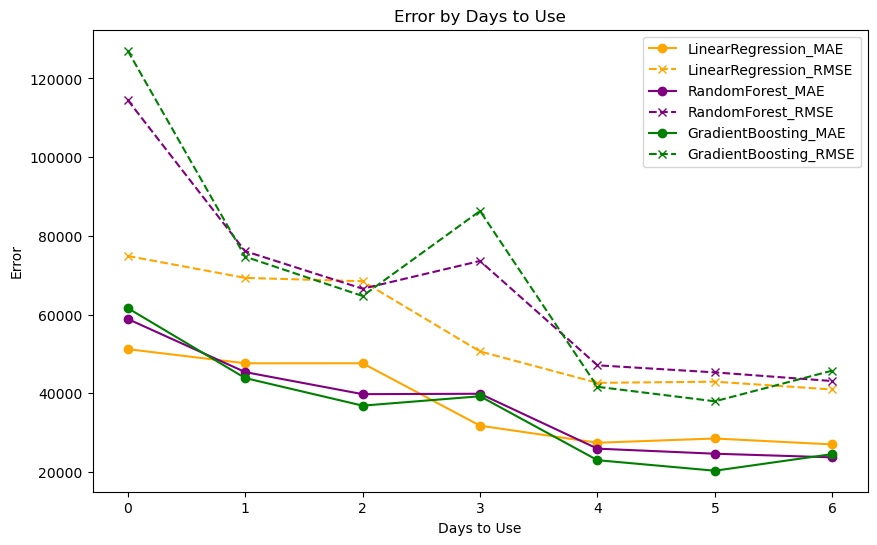

In [23]:
# 0~7일 데이터를 사용하여 11일 예측 평균 에러 시각화 (모델별 다른 선으로 표시)
colors = ['orange', 'purple', 'green']

plt.figure(figsize=(10, 6))
for model_name, color in zip(results_df['Model'].unique(), colors):
    model_results = results_df[(results_df['Model'] == model_name) & (results_df['Predict Day'] == 11)]
    plt.plot(model_results['Days to Use'], model_results['MAE'], label=model_name+'_MAE', color=color, marker='o')
    plt.plot(model_results['Days to Use'], model_results['RMSE'], label=model_name+'_RMSE', color=color, linestyle='--', marker='x')

plt.xlabel('Days to Use')
plt.ylabel('Error')
plt.title('Error by Days to Use')
plt.legend()
plt.show()

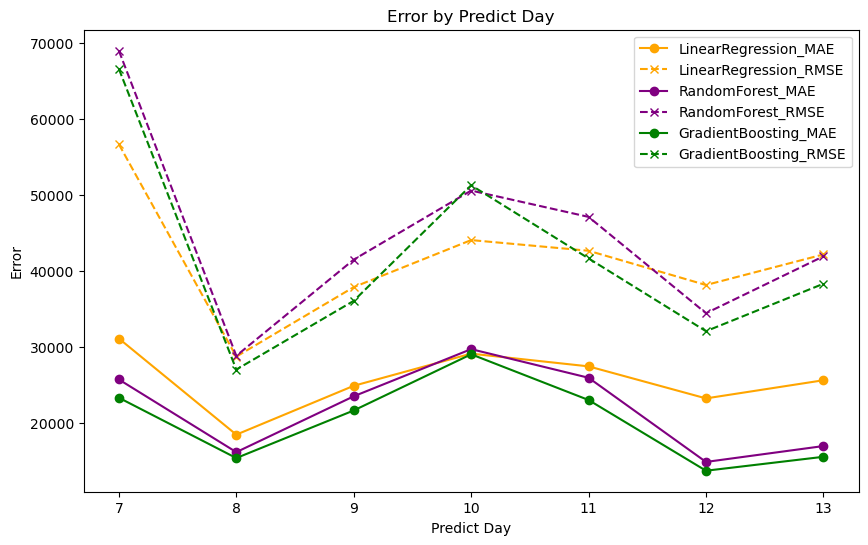

In [24]:
# 4일 데이터를 사용하여 8~14일 예측 평균 에러 시각화 (모델별 다른 선으로 표시)
colors = ['orange', 'purple', 'green']

plt.figure(figsize=(10, 6))
for model_name, color in zip(results_df['Model'].unique(), colors):
    model_results = results_df[(results_df['Model'] == model_name) & (results_df['Days to Use'] == 4)]
    plt.plot(model_results['Predict Day'], model_results['MAE'], label=model_name+'_MAE', color=color, marker='o')
    plt.plot(model_results['Predict Day'], model_results['RMSE'], label=model_name+'_RMSE', color=color, linestyle='--', marker='x')

plt.xlabel('Predict Day')
plt.ylabel('Error')
plt.title('Error by Predict Day')
plt.legend()
plt.show()

In [79]:
# Read in list of movie codes
with open('y_test_week_2.txt', 'r') as f:
    y_test_week_2 = f.read().splitlines()

# change to integer
y_test_index_week_2 = [int(x) for x in y_test_week_2]

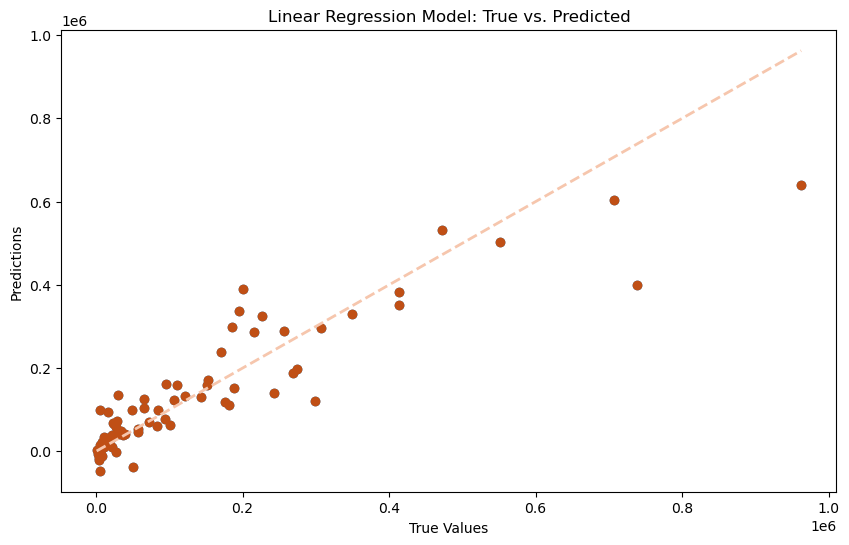

In [80]:
# 독립변수와 종속변수 준비
X, y = create_X_y(data2, days_to_use=4, predict_day=10)

# 예측할 영화만 추출
X_train = X[~X.index.get_level_values('kobis_movie_code').isin(y_test_index_week_2)]
X_test = X[X.index.get_level_values('kobis_movie_code').isin(y_test_index_week_2)]
y_train = y[~y.index.get_level_values('kobis_movie_code').isin(y_test_index_week_2)]
y_test = y[y.index.get_level_values('kobis_movie_code').isin(y_test_index_week_2)]

# X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.2, random_state=33)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='#F6C6AD')
plt.scatter(y_test, y_pred, color='#C04F15')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear Regression Model: True vs. Predicted')
plt.show()

In [81]:
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 45883.82917357877
RMSE: 76139.45310539374
MAPE: 1.1935429823330492


In [27]:
# 모델 생성
model = sm.OLS(y, sm.add_constant(X))

# 모델 학습
result = model.fit()

# 결과 출력
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    관객수   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     174.5
Date:                Wed, 11 Dec 2024   Prob (F-statistic):          6.69e-146
Time:                        12:00:31   Log-Likelihood:                -4809.5
No. Observations:                 391   AIC:                             9645.
Df Residuals:                     378   BIC:                             9697.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
관객수_0         -0.3159      0.042     -7.469      0.0

## 3주차 관객수 예측

In [28]:
# 데이터 불러오기
post_14_data = pd.read_csv('processed_data/audi_cnt_after_14.csv')
post_14_data.head()

,movieCd,movieNm,openDt,date,D_D,audiCnt
0,20068576,그날의 분위기,2016-01-14,2016-01-28,14,4229
1,20068576,그날의 분위기,2016-01-14,2016-01-31,17,6317
2,20068576,그날의 분위기,2016-01-14,2016-01-30,16,6650
3,20068576,그날의 분위기,2016-01-14,2016-02-01,18,2750
4,20068576,그날의 분위기,2016-01-14,2016-02-02,19,2573


In [29]:
# 데이터 전처리
post_14_data['date'] = pd.to_datetime(post_14_data['date'])
post_14_data['Weekend'] = post_14_data['date'].dt.day_name().apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
post_14_data['Vacation'] = post_14_data['date'].dt.month.apply(lambda x: 1 if x in [1, 2, 7, 8] else 0)
post_14_data['Holiday'] = post_14_data['date'].apply(lambda x: 1 if x in kr_holidays else 0)
post_14_data.head()

,movieCd,movieNm,openDt,date,D_D,audiCnt,Weekend,Vacation,Holiday
0,20068576,그날의 분위기,2016-01-14,2016-01-28,14,4229,0,1,0
1,20068576,그날의 분위기,2016-01-14,2016-01-31,17,6317,1,1,0
2,20068576,그날의 분위기,2016-01-14,2016-01-30,16,6650,1,1,0
3,20068576,그날의 분위기,2016-01-14,2016-02-01,18,2750,0,1,0
4,20068576,그날의 분위기,2016-01-14,2016-02-02,19,2573,0,1,0


In [30]:
columns_to_pivot = ['관객수', '영화명_검색량']

# 독립변수와 종속변수를 분리
def create_X_y_2(data, post_14_data, columns_to_pivot, days_to_use, predict_day):

    # 예측 날짜에서 관심 있는 변수만 추출
    data_N = post_14_data[post_14_data['D_D'] == predict_day].copy()
    data_N.rename(columns={'movieCd': 'kobis_movie_code', 'movieNm':'movie_title', 'audiCnt':'관객수'}, inplace=True)
    filtered_data_N = data_N[['kobis_movie_code', 'movie_title', 'Weekend', 'Vacation', 'Holiday']].set_index(['kobis_movie_code', 'movie_title'])

    # 14일 이내 데이터에서 필터링
    data_n = data[data['D_D'] <= days_to_use].copy()
    pivoted_data_n = data_n.pivot(index=['kobis_movie_code', 'movie_title'], columns='D_D', values=columns_to_pivot)

    # MultiIndex 컬럼을 단순화
    pivoted_data_n.columns = [f"{col[0]}_{col[1]}" for col in pivoted_data_n.columns]

    pre_X = pivoted_data_n.merge(filtered_data_N, left_index=True, right_index=True)
    pre_y = data_N[data_N['D_D'] == predict_day][['kobis_movie_code', 'movie_title', '관객수']].set_index(['kobis_movie_code', 'movie_title'])

    df = pre_X.merge(pre_y, left_index=True, right_index=True)

    X = df.drop(columns=['관객수'])
    y = df['관객수']

    return X, y

In [31]:
# 모델별 결과 저장
results2 = []

# 회귀 모델 리스트
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 사용할 데이터 일수 정의
for days_to_use in range(7, 14):
    # 예측할 날짜 정의
    for predict_day in range(14, 21):
        # 데이터 생성
        X, y = create_X_y_2(data2, post_14_data, columns_to_pivot, days_to_use, predict_day)

        # 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.2, random_state=33)

        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = root_mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)

            results2.append({
                'Model': model_name,
                'Days to Use': days_to_use,
                'Predict Day': predict_day,
                'train_R^2': model.score(X_train, y_train),
                'test_R^2': model.score(X_test, y_test),
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape
            })

# 결과 출력
results_df2 = pd.DataFrame(results2)
results_df2

,Model,Days to Use,Predict Day,train_R^2,test_R^2,RMSE,MAE,MAPE
0,LinearRegression,7,14,0.583225,-1.522810,58543.266799,35359.877005,3.269363
1,RandomForest,7,14,0.833389,0.061069,35715.072449,21141.776471,1.683318
2,GradientBoosting,7,14,0.996034,0.278634,31304.905224,19556.115967,1.515759
3,LinearRegression,7,15,0.546012,0.638470,21663.660037,16094.987603,1.792012
4,RandomForest,7,15,0.899029,0.768355,17340.875084,10475.336444,0.640549
...,...,...,...,...,...,...,...,...
142,RandomForest,13,19,0.942888,0.728324,16785.977233,9004.186429,0.604451
143,GradientBoosting,13,19,0.997464,0.720153,17036.540175,8266.823905,0.530231
144,LinearRegression,13,20,0.870336,0.490601,14991.650142,9411.402510,1.214879
145,RandomForest,13,20,0.960871,0.549894,14092.158794,8122.394103,0.666203


In [32]:
results_df2.groupby('Model')[['train_R^2', 'test_R^2', 'MAE', 'RMSE', 'MAPE']].mean()

,train_R^2,test_R^2,MAE,RMSE,MAPE
Model,,,,,
GradientBoosting,0.995100,0.527197,17590.981329,32850.991645,0.929338
LinearRegression,0.759551,0.165902,21861.127481,36047.305724,1.600899
RandomForest,0.923524,0.561719,17193.649225,31485.527403,0.895216


In [33]:
results_df2[results_df2['Model'] == 'LinearRegression'].groupby('Days to Use')[['MAE', 'RMSE', 'MAPE']].mean()

,MAE,RMSE,MAPE
Days to Use,,,
7,25372.480520,39324.449747,2.106946
8,25913.174476,44424.485216,1.942508
9,25142.183732,42470.940400,1.722538
10,20769.624775,35061.122840,1.494977
11,20563.168534,34330.682086,1.450623
12,18381.016216,28921.293571,1.313046
13,16886.244113,27798.166207,1.175654


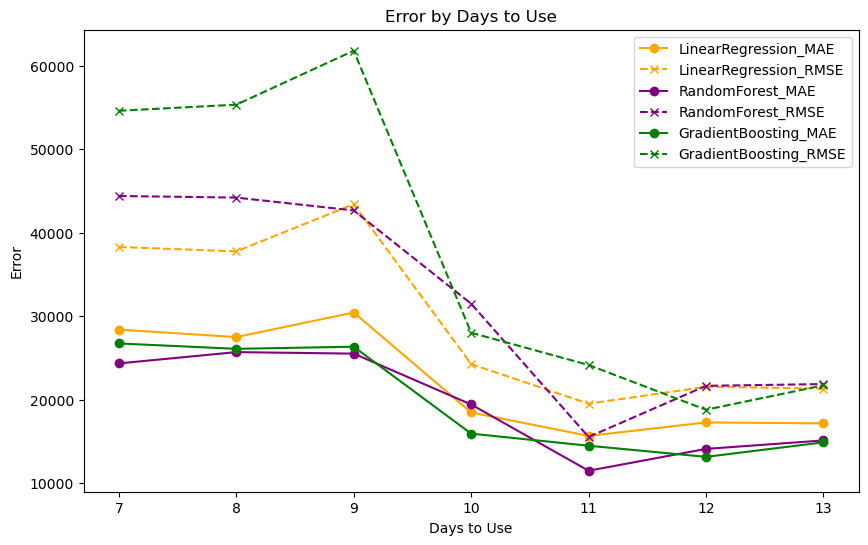

In [41]:
# 0~7일 데이터를 사용하여 11일 예측 평균 에러 시각화 (모델별 다른 선으로 표시)
colors = ['orange', 'purple', 'green']

plt.figure(figsize=(10, 6))
for model_name, color in zip(results_df['Model'].unique(), colors):
    model_results = results_df2[(results_df2['Model'] == model_name) & (results_df2['Predict Day'] == 18)]
    plt.plot(model_results['Days to Use'], model_results['MAE'], label=model_name+'_MAE', color=color, marker='o')
    plt.plot(model_results['Days to Use'], model_results['RMSE'], label=model_name+'_RMSE', color=color, linestyle='--', marker='x')

plt.xlabel('Days to Use')
plt.ylabel('Error')
plt.title('Error by Days to Use')
plt.legend()
plt.show()

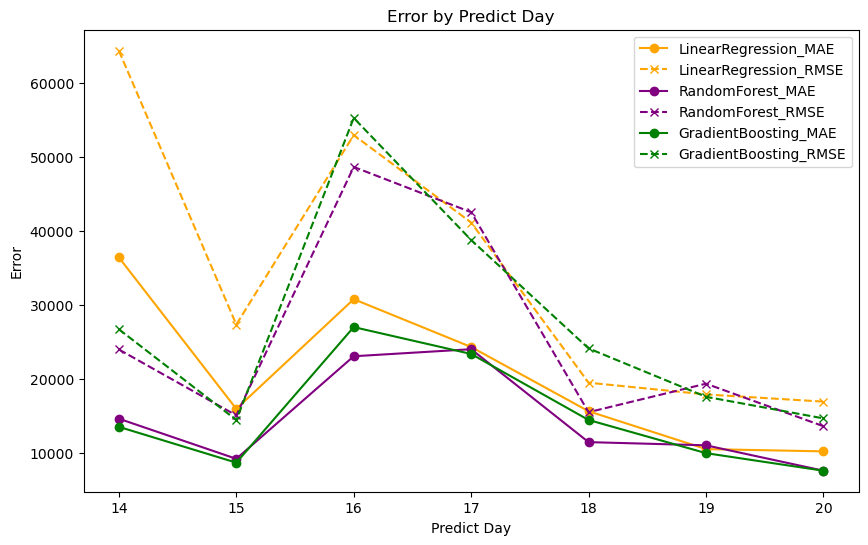

In [34]:
# 11일 데이터를 사용하여 14~20일 예측 평균 에러 시각화 (모델별 다른 선으로 표시)
colors = ['orange', 'purple', 'green']

plt.figure(figsize=(10, 6))
for model_name, color in zip(results_df2['Model'].unique(), colors):
    model_results = results_df2[(results_df2['Model'] == model_name) & (results_df2['Days to Use'] == 11)]
    plt.plot(model_results['Predict Day'], model_results['MAE'], label=model_name+'_MAE', color=color, marker='o')
    plt.plot(model_results['Predict Day'], model_results['RMSE'], label=model_name+'_RMSE', color=color, linestyle='--', marker='x')

plt.xlabel('Predict Day')
plt.ylabel('Error')
plt.title('Error by Predict Day')
plt.legend()
plt.show()

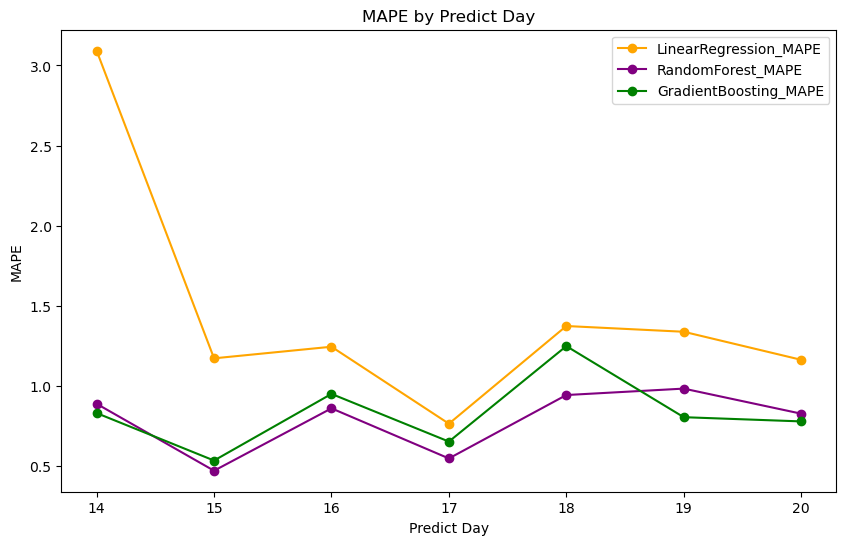

In [35]:
# 11일 데이터를 사용하여 14~20일 예측 MAPE 시각화 (모델별 다른 선으로 표시)
colors = ['orange', 'purple', 'green']

plt.figure(figsize=(10, 6))
for model_name, color in zip(results_df2['Model'].unique(), colors):
    model_results = results_df2[(results_df2['Model'] == model_name) & (results_df2['Days to Use'] == 11)]
    plt.plot(model_results['Predict Day'], model_results['MAPE'], label=model_name+'_MAPE', color=color, marker='o')

plt.xlabel('Predict Day')
plt.ylabel('MAPE')
plt.title('MAPE by Predict Day')
plt.legend()
plt.show()

In [70]:
# Read in list of movie codes
with open('y_test_week_3.txt', 'r') as f:
    y_test_week_3 = f.read().splitlines()

# change to integer
y_test_index_week_3 = [int(x) for x in y_test_week_3]

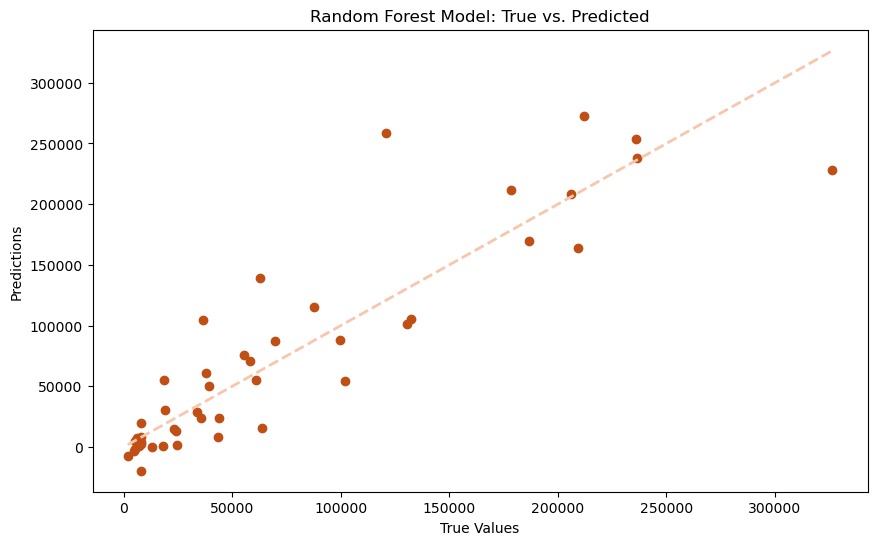

In [74]:
# 독립변수와 종속변수 준비
X, y = create_X_y_2(data2, post_14_data, columns_to_pivot, days_to_use=11, predict_day=17)

# Split train and test data by what is in y_test_index_week_3
X_train = X[~X.index.get_level_values('kobis_movie_code').isin(y_test_index_week_3)]
y_train = y[~y.index.get_level_values('kobis_movie_code').isin(y_test_index_week_3)]

X_test = X[X.index.get_level_values('kobis_movie_code').isin(y_test_index_week_3)]
y_test = y[y.index.get_level_values('kobis_movie_code').isin(y_test_index_week_3)]

# X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.2, random_state=33)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='#F6C6AD')
plt.scatter(y_test, y_pred, color='#C04F15')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Random Forest Model: True vs. Predicted')
plt.show()

In [75]:
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 24268.271253393108
RMSE: 36317.4468699558
MAPE: 0.7137993726573594


In [38]:
# 모델 생성
model = sm.OLS(y, sm.add_constant(X))

# 모델 학습
result = model.fit()

# 결과 출력
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    관객수   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     56.75
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           1.57e-79
Time:                        12:01:00   Log-Likelihood:                -2754.0
No. Observations:                 233   AIC:                             5562.
Df Residuals:                     206   BIC:                             5655.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
관객수_0          0.0818      0.031      2.616      0.0

In [39]:
y_test

array([  2469, 205879, 239654, 171009,   4206,  10419,   8302, 230186,
        38789, 241608,  19159,  12739,   7969,  13387, 141609,  58241,
       177961, 196946,  16771,  18287,  85482,  11967, 130367,   8190,
         5195,  55314,  35909,   4662,   5951, 132266, 129922,  53664,
        20068,   6888,  16771,  12824,  24594,  11276, 137047,   8182,
        94209,  43746, 169265,   6226,  54193,  15570,  14208],
      dtype=int64)